In [1]:
%matplotlib nbagg
import time
import h5py
import matplotlib.pylab as plt
import numpy as np
import dedalus.public as de
from dedalus.extras import flow_tools

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [3]:
nr = 256

r_in = 5. # cm
r_out = 3*r_in
h = 10. # cm

nu = 3.26e-3 # cm^2/s
eta = 2000 # cm^2/s
rho = 6 # g/cm^3
B0 = 3000 # G

In [4]:
d = r_out - r_in
eps = h/d
K = np.pi/h * np.sqrt(1+eps**2)
Omega_in = 314 # rad/s
Omega_out = 37.9 # rad/s
Re_in = Omega_in/(nu*K**2)
Re_out = Omega_out/(nu*K**2)
zeta_bar = 2*(r_out**2 * Omega_out - r_in**2 * Omega_in)/((r_out**2 - r_in**2)*np.sqrt(Omega_in*Omega_out))
print("Re_in = {}; Re_out = {}".format(Re_in,Re_out))
print("zeta bar = {}".format(zeta_bar))

Re_in = 487957.8476026697; Re_out = 58896.823006819046
zeta bar = 0.062104757527239964


In [5]:
r = de.Chebyshev('r',nr,interval=[r_in, r_out])
domain = de.Domain([r])#,grid_dtype=np.double)

nr2 = 384
r2 = de.Chebyshev('r',nr2,interval=[r_in, r_out])
domain2 = de.Domain([r2])#,grid_dtype=np.double)

In [6]:
r_g = r.grid()

In [8]:
c2 = (Omega_out - Omega_in)/(1/r_out**2 - 1/r_in**2)
c1 = Omega_in - c2/r_in**2

Omega = c1 + c2/r_g**2

In [9]:
omega = domain.new_field()
vorticity = domain.new_field()
r2_omega = domain.new_field()

In [10]:
variables = ['psi', 'u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br']
gmri1 = de.EVP(domain,variables, 'sigma')
gmri2 = de.EVP(domain2,variables, 'sigma')

for gmri in [gmri1, gmri2]:
    gmri.parameters['nu'] = nu
    gmri.parameters['eta'] = eta
    gmri.parameters['rho'] = rho
    gmri.parameters['B0'] = B0
    gmri.parameters['pi'] = np.pi
    gmri.parameters['k'] = np.pi/h
    gmri.parameters['c1'] = c1
    gmri.parameters['c2'] = c2
    gmri.substitutions['u0'] = '(c1*r + c2/r)'
    gmri.substitutions['inv4pirho'] = '(1/(4*pi*rho))'
    gmri.substitutions['psivisc'] = 'r**2*k**2*psir - r**3*k**2*psirr - 3*psir + 3*r*psirr - 2*r**2*psirrr + r**3*dr(psirrr) + r**3*k**4*psi + r**2*k**2*psir - r**3*k**2*psirr'
    gmri.substitutions['uvisc'] = '-r**2*k**2*u + r**2*dr(ur) + r*ur - u'
    gmri.substitutions['Avisc'] = 'r**2*dr(Ar) - r**2*k**2*A - r*Ar + 0.5*A'
    gmri.substitutions['Bvisc'] = '-r**2*k**2*psi + r**2*psirr + r*psir - B'

2016-05-03 21:27:11,035 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-05-03 21:27:11,037 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [11]:
for gmri in [gmri1, gmri2]:
    gmri.add_equation("sigma*(r**3*k**2*psi + r**3*psirr - r**2*psir) - r**3*2*u0*1j*k*u + r**3*inv4pirho*B0*1j*k**3*A + inv4pirho*B0*r**2*1j*k*Ar - inv4pirho*r**3*B0*1j*k*dr(Ar) - nu*psivisc = 0")
    gmri.add_equation("sigma*r**2*u + u0*1j*k*psi + r*dr(u0)*1j*k*psi - r**2*inv4pirho*B0*1j*k*B - nu*uvisc = 0")
    gmri.add_equation("sigma*r**2*A - r**2*B0*1j*k*psi - eta*Avisc = 0")
    gmri.add_equation("sigma*r**2*B + u0*1j*k*A - r**2*B0*1j*k*u - r*1j*k*dr(u0)*A - eta*Bvisc = 0")

In [12]:
for gmri in [gmri1, gmri2]:
    gmri.add_equation("dr(psi) - psir = 0")
    gmri.add_equation("dr(psir) - psirr = 0")
    gmri.add_equation("dr(psirr) - psirrr = 0")
    gmri.add_equation("dr(u) - ur = 0")
    gmri.add_equation("dr(A) - Ar = 0")
    gmri.add_equation("dr(B) - Br = 0")

In [13]:
for gmri in [gmri1, gmri2]:
    gmri.add_bc('left(u) = 0')
    gmri.add_bc('right(u) = 0')
    gmri.add_bc('left(psi) = 0')
    gmri.add_bc('right(psi) = 0')
    gmri.add_bc('left(A) = 0')
    gmri.add_bc('right(A) = 0')
    gmri.add_bc('left(psir) = 0')
    gmri.add_bc('right(psir) = 0')
    gmri.add_bc('left(B + r*Br) = 0')
    gmri.add_bc('right(B + r*Br) = 0')

In [14]:
gmri_solver1 = gmri1.build_solver()
gmri_solver2 = gmri2.build_solver()

In [15]:
gmri_solver1.solve(gmri_solver1.pencils[0])
gmri_solver2.solve(gmri_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [16]:
def discard_spurious_eigenvalues(lambda1, lambda2):

    """
    lambda1 :: eigenvalues from low res run
    lambda2 :: eigenvalues from high res run

    Solves the linear eigenvalue problem for two different resolutions.
    Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
    """

    # Reverse engineer correct indices to make unsorted list from sorted
    reverse_lambda1_indx = np.arange(len(lambda1)) 
    reverse_lambda2_indx = np.arange(len(lambda2))

    lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
    lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))

    # remove nans
    lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
    lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]

    # Sort lambda1 and lambda2 by real parts
    lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
    lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]

    lambda1_sorted = lambda1_and_indx[:, 0]
    lambda2_sorted = lambda2_and_indx[:, 0]

    # Compute sigmas from lower resolution run (gridnum = N1)
    sigmas = np.zeros(len(lambda1_sorted))
    sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
    sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
    sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

    if not (np.isfinite(sigmas)).all():
        print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")

    # Nearest delta
    delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])

    # Discard eigenvalues with 1/delta_near < 10^6
    lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
    #print(lambda1_and_indx)

    lambda1 = lambda1_and_indx[:, 0]
    indx = lambda1_and_indx[:, 1]

    return lambda1, indx

In [17]:
# Discard spurious eigenvalues
ev1 = gmri_solver1.eigenvalues
ev2 = gmri_solver2.eigenvalues
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)

In [18]:
goodeigs_index = np.nanargmax(goodeigs.real)
marginal_mode_index = int(goodeigs_indices[goodeigs_index])

gmri_solver1.set_state(marginal_mode_index)

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [19]:
goodeigs[goodeigs_index]

(211.51868040118333-637.47501488166324j)

In [20]:
np.nanmin(np.abs(goodeigs.real))

89.696158391779051

In [21]:
u = 1j*(np.pi/10)*(1/r_g)*gmri_solver1.state['psi']['g']
v = gmri_solver1.state['u']['g']
w = (-1/r_g)*gmri_solver1.state['psir']['g']
Br = 1j*(np.pi/10)*(1/r_g)*gmri_solver1.state['Ar']['g']
Bphi = gmri_solver1.state['B']['g']
Bz = (-1/r_g)*gmri_solver1.state['Ar']['g']

scale_factor = 2.7/np.abs(v).max()

<IPython.core.display.Javascript object>


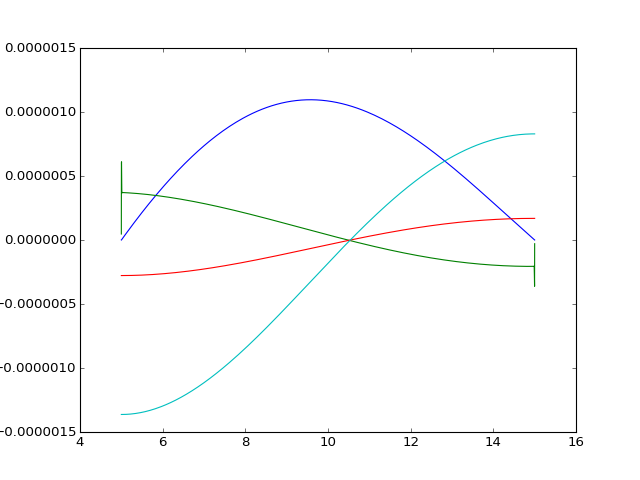

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [22]:
plt.figure()
plt.plot(r_g, u)
plt.plot(r_g, w)
plt.plot(r_g, Br)
plt.plot(r_g, Bz)

In [23]:
len(v)

256

<IPython.core.display.Javascript object>


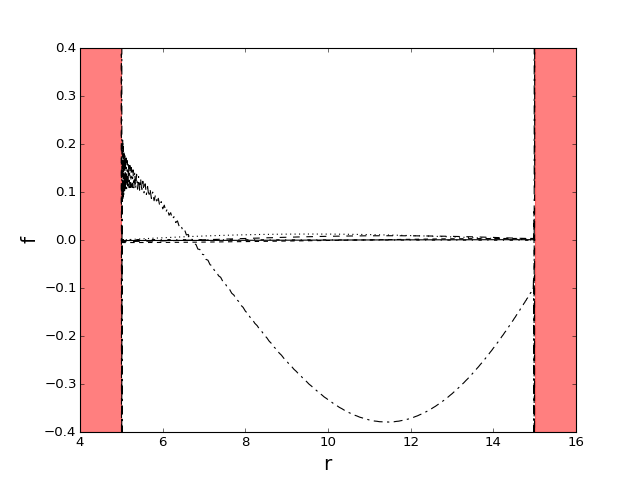

(-0.4, 0.4)

In [29]:
plt.figure()

plt.plot(r_g,scale_factor*v,'k',ls='--')
plt.plot(r_g,scale_factor*u/3.,'k',ls='dotted')
plt.plot(r_g,scale_factor*w*0.07,'k',ls='-.')
plt.plot(r_g,scale_factor*Br/np.sqrt(4*np.pi*rho),'k')
plt.plot(r_g,scale_factor*Bphi/np.sqrt(4*np.pi*rho)*5,'k',dashes=[2,4,8,4])
plt.plot(r_g,scale_factor*Bz/np.sqrt(4*np.pi*rho),'k',dashes=[4,4])
plt.xlabel('r', fontsize=18)
plt.ylabel('f', fontsize=18)
plt.axvspan(4, 5, alpha=0.5, color='red')
plt.axvspan(15, 16, alpha=0.5, color='red')

plt.xlim(4,16)
#plt.ylim(-10, 10)
plt.ylim(-0.4,0.4)